# Parent Child Political Correlation
Studying the correlation between parent's political affiliations and involvements and the political affiliations and involvement of their children.

Importing packages:

In [211]:
import pandas as pd
import numpy as np
import os
from empiricaldist import Pmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

Unpack the tar file if the data file is not already uncompressed on this machine:

In [212]:
if not os.path.exists('anes_timeseries_cdf_rawdata.txt'):
    !tar -xvf data.tar.bz2

Import the data and save as dataframe:

In [213]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

## Load & Prepare the Data

In [214]:
anes = pd.read_csv('anes_timeseries_cdf_rawdata.txt', delimiter=',', low_memory=False, na_values=[' ','  '])
anes

,Version,VCF0004,VCF0006,VCF0006a,VCF0009x,VCF0010x,VCF0011x,VCF0009y,VCF0010y,VCF0011y,...,VCF9272,VCF9273,VCF9274,VCF9275,VCF9277,VCF9278,VCF9279,VCF9280,VCF9281,VCF9282
0,ANES_CDF_VERSION:2019-Sep-10,1948,1001,19481001,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANES_CDF_VERSION:2019-Sep-10,1948,1002,19481002,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ANES_CDF_VERSION:2019-Sep-10,1948,1003,19481003,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ANES_CDF_VERSION:2019-Sep-10,1948,1004,19481004,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ANES_CDF_VERSION:2019-Sep-10,1948,1005,19481005,1.0,1.0,1.0,1.000,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59939,ANES_CDF_VERSION:2019-Sep-10,2016,5086,20165086,0.0,0.0,0.0,0.818,0.818,0.818,...,2.0,1.0,NaN,3.0,1.0,2.0,1.0,1.0,1.0,1.0
59940,ANES_CDF_VERSION:2019-Sep-10,2016,5087,20165087,0.0,0.0,0.0,1.280,1.280,1.280,...,3.0,6.0,NaN,2.0,-9.0,-9.0,1.0,2.0,1.0,1.0
59941,ANES_CDF_VERSION:2019-Sep-10,2016,5088,20165088,0.0,0.0,0.0,3.788,3.788,3.788,...,1.0,5.0,NaN,2.0,-9.0,-9.0,1.0,2.0,1.0,1.0
59942,ANES_CDF_VERSION:2019-Sep-10,2016,5089,20165089,0.0,0.0,0.0,1.162,1.162,1.162,...,2.0,2.0,NaN,3.0,2.0,2.0,1.0,2.0,1.0,1.0


Load and clean general statistics (gender, race, socio economic status, age, education):

In [215]:
gender = anes['VCF0104']
gender.name='gender'
values(gender)

0      144
1    26849
2    32940
3       11
Name: gender, dtype: int64

And clean the gender variable. 0 corresponds to NA and 3 is other (it pains me to remove this, but the sample size is too small). 1 corresponds to male and 2 to female.

In [6]:
remap = {1: 'male',
         2: 'female',
         0: np.nan,
         3: np.nan}
gender = gender.replace(remap)
values(gender)

female    32940
male      26849
Name: gender, dtype: int64

In [7]:
race = anes['VCF0105b'].replace([9, 0], np.nan) # 9 is NA/missing, 0 is missing
race.name='race'
remap = {1: 'white',
         2: 'black',
         3: 'hispanic',
         4: 'other'}
race = race.replace(remap)
values(race)

black        6906
hispanic     3942
other        1466
white       46035
Name: race, dtype: int64

In [8]:
income = anes['VCF0114'].replace(0, np.nan) # 0 is don't know or NA
remap = {1: 'lower',
         2: 'lowerMiddle',
         3: 'middle',
         4: 'upperMiddle',
         5: 'upper'}
income = income.replace(remap)
income.name='income'
values(income)

lower           9474
lowerMiddle     9064
middle         17868
upper           2835
upperMiddle    15254
Name: income, dtype: int64

Here is the translation guide from income percent to class:

Percentile | Class Label
--- | ---
0 to 16 percentile | Lower
17 to 33 percentile | Lower Middle
34 to 67 percentile | Middle
68 to 95 percentile | Upper Middle
96 to 100 percentile | Upper

In [9]:
age = anes['VCF0102'].replace(0, np.nan) # 0 is NA or Don't Know
age.name='age'
remap = {1: '17-24',
         2: '25-34',
         3: '35-44',
         4: '45-54',
         5: '55-64',
         6: '65-74',
         7: '75-99'}
age = age.replace(remap)
values(age)

17-24     5630
25-34    12241
35-44    11838
45-54    10106
55-64     8970
65-74     6787
75-99     3818
Name: age, dtype: int64

In [10]:
educ = anes['VCF0110'].replace(0, np.nan) # 0 is DK, NA (used 4 category for easy of data, there are also 6 and 7 category versions)
remap = {1: 'Grade School',
         2: 'High School',
         3: 'Some College',
         4: 'College Degree'}
educ = educ.replace(remap)
educ.name='educ'
values(educ)

College Degree    12011
Grade School       8098
High School       25884
Some College      13360
Name: educ, dtype: int64

1. 8 grades or less ('grade school')
2. 9-12 grades ('high school'), no diploma/equivalency
3. 12 grades, diploma or equivalency
4. 12 grades, diploma or equivalency plus non-academic training
5. Some college, no degree; junior/community college level degree (AA degree)
6. BA level degrees
7. Advanced degrees incl. LLB

Load and clean the variables for the respondent's parent's political affiliation:

In [11]:
fatherPol = anes['VCF0306'].replace([0, 4, 9], np.nan)
# 0, 4, and 9 represent "NA", "Other" and  "Don't know" respectively
remap = {1: 'Democrat',
         2: 'Independent',
         3: 'Republican'}
fatherPol = fatherPol.replace(remap)
fatherPol.name='DadPol'
values(fatherPol)

Democrat       9747
Independent    1355
Republican     5351
Name: DadPol, dtype: int64

In [12]:
motherPol = anes['VCF0307'].replace([0, 4, 9], np.nan)
remap = {1: 'Democrat',
         2: 'Independent',
         3: 'Republican'}
motherPol = motherPol.replace(remap)
motherPol.name='MomPol'
values(motherPol)

Democrat       9337
Independent    1416
Republican     5061
Name: MomPol, dtype: int64

Here is a seven point political affilation scale:

Where:

0. NA
1. Strong Democrat
2. Weak Democrat
3. Independent -Democrat
4. Independent -Independent
5. Independent -Republican
6. Weak Republican
7. Strong Republican

In [13]:
pol7 = anes['VCF0301'].replace(0, np.nan)
pol7.name='pol7'
values(pol7)

1.0    11695
2.0    11820
3.0     6886
4.0     6988
5.0     5882
6.0     7921
7.0     7075
Name: pol7, dtype: int64

A simple three point scale, just like in the variable booklet (including leaners):

In [14]:
remap = {1: 1,
         2: 1,
         3: 1,
         4: 2,
         5: 3,
         6: 3,
         7: 3}
pol = pol7.replace(remap)
pol.name='pol'
values(pol)

1.0    30401
2.0     6988
3.0    20878
Name: pol, dtype: int64

In [15]:
year = anes['VCF0004']
year.name='Year'
year

0        1948
1        1948
2        1948
3        1948
4        1948
         ... 
59939    2016
59940    2016
59941    2016
59942    2016
59943    2016
Name: Year, Length: 59944, dtype: int64

# Data Verification
To make sure all variables loaded correctly, I verified the data by testing a random year for each one. To do this, I used the [individual year](https://electionstudies.org/data-center/) time series links from the ANES site.

**Gender**

Expected:
1. 1327 female respondents
2. 1158 male respondents

In [16]:
values(gender[(year == 1992)])

female    1327
male      1158
Name: gender, dtype: int64

**Race**

Expected:
1. 1340 white
2. 145 black
3. 14 hispanic
4. 8 other

In [17]:
values(race[(year == 1970)])

black        145
hispanic      14
other          8
white       1340
Name: race, dtype: int64

**Income**

Due to the inconsistent value reporting for the income grouping, it was not possible to accurately validate my income data.


**Age**

Expected:
1. 17-24 -> 328
2. 25-34 -> 710
3. 35-44 -> 655
4. 45-54 -> 688
5. 55-64 -> 817
6. 65-74 -> 623
7. 75-99 -> 328

In [18]:
values(age[(year == 2016)])

17-24    328
25-34    710
35-44    655
45-54    688
55-64    817
65-74    623
75-99    328
Name: age, dtype: int64

**Education**

Expected:
1. Grade School: 199
2. High School: 957
3. Some College: 450
4. College Degree: 397

In [19]:
values(educ[(year == 1988)])

College Degree    397
Grade School      199
High School       957
Some College      450
Name: educ, dtype: int64

**Father Political Affiliation**

Expected:
1. 1282 Democrats
2. 166 Independetns
3. 690 Republicans

In [20]:
values(fatherPol[(year == 1972)])

Democrat       1282
Independent     166
Republican      690
Name: DadPol, dtype: int64

**Mother Political Affiliation**

Expected:
1. 1277 Democrats
2. 178 Independents
3. 654 Republicans

In [21]:
values(motherPol[(year == 1972)])

Democrat       1277
Independent     178
Republican      654
Name: MomPol, dtype: int64

**Political Affiliation**

Expected:
1. 286 Strong Democrats
2. 372 Weak Democrats
3. 184 Independent - Democrats
4. 243 Independent - Independent
5. 165 Independent - Republican
6. 225 Weak Republican
7. 137 Strong Republican

In [22]:
values(pol7[(year == 1980)])

1.0    286
2.0    371
3.0    184
4.0    243
5.0    166
6.0    225
7.0    137
Name: pol7, dtype: int64

These values do not seem to be exact, though they are incredibly close. I am not sure what is causing this. In the name of time, I kept going as the data looked good overall.

A dataframe to keep all the data organized for later analysis:

In [23]:
d = {'year': year, 'gender': gender, 'race': race, 'income': income, 'age': age, 'educ':educ, 
     'fatherPol':fatherPol, 'motherPol': motherPol, 'pol': pol, 'pol7': pol7, 'weight':anes['VCF0009x']}
data = pd.DataFrame(data=d)
data

,year,gender,race,income,age,educ,fatherPol,motherPol,pol,pol7,weight
0,1948,male,white,middle,35-44,Grade School,NaN,NaN,NaN,NaN,1.0
1,1948,female,white,upper,35-44,High School,NaN,NaN,NaN,NaN,1.0
2,1948,female,white,upperMiddle,25-34,High School,NaN,NaN,NaN,NaN,1.0
3,1948,female,white,upper,35-44,Some College,NaN,NaN,NaN,NaN,1.0
4,1948,male,white,upperMiddle,25-34,Some College,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
59939,2016,female,white,upperMiddle,35-44,College Degree,NaN,NaN,1.0,1.0,0.0
59940,2016,male,white,NaN,75-99,High School,NaN,NaN,1.0,1.0,0.0
59941,2016,male,white,lower,25-34,High School,NaN,NaN,1.0,2.0,0.0
59942,2016,female,black,lower,35-44,Some College,NaN,NaN,1.0,1.0,0.0


## Resampling and Weighting

In [24]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

In [25]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby('year') # group by year
    samples = [resample_rows_weighted(group, column)
               for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

Resample with the weights specified by the ANES codebook:

In [61]:
data = resample_by_year(data, 'weight')
s2 = resample_by_year(data, 'weight')
s3 = resample_by_year(data, 'weight')

I created three samples to look at resampling of the data when looking at trend lines later on, especially when they are over time and the results could vary with a resampling.

# Analysis
Let's look at how each variable  correlates with political affiliation:
* Year
* Gender
* Race and Ethnicity
* Socio economic status
* Age
* Mother's political affiliation
* Father's political affiliation

First some functions to help with plotting. The functions "decorate", "make_lowess", "plot_series_lowess", "plot_columns_lowess", and "anchor_legend" originally from Allen Downey's Data Science course for Olin College.

In [62]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [63]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [64]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

In [65]:
def plot_columns_lowess(table, columns, colors):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, colors[col])

In [66]:
def anchor_legend(x, y):
    """Place the upper left corner of the legend box.
    
    x: x coordinate
    y: y coordinate
    """
    plt.legend(bbox_to_anchor=(x, y), loc='upper left', ncol=1)

In [67]:
import itertools
def annotateBars(pmf, xOffset, y, barCount, fontsize):
    """Annotate bars with their values.
    
    pmf: pmf
    xOffset: x offset to calculate x position
    y: y position
    barCount: number of bars per point
    fontsize: fontsize in pixels
    """
    xScale = pmf.qs[0]
    fontsize = fontsize
#     fontsize = (20/barCount)*(10/len(pmf)) # account for number of bars and the width of the plot (based on points on scale)
#     if fontsize > 24:
#         fontsize = 24
    
    for (x, val) in zip(pmf.qs, pmf.values):
        val = round(val, 2)
        x = x + xOffset - xScale/10 # center on bar
        plt.text(x, y, str(val).strip('0'), fontstyle='oblique', fontweight=600, fontsize=fontsize, rotation=45)

In [284]:
def pmfComparison(data, fontsize=15, xOffset=0, yOffset=0, pColor='colorblind', **options):
    """Create bar plot via pmf to compare data.
    
    data: list of pd.Series
    fontsize: fontsize for annotate text
    xOffset: x offset for annotate text
    yOffset: y offset for annotate text
    pColor: seaborn color pallete
    **options: options to pass to matplotlib bar plot
    """
    labels = [] # series labels
    pmfList = [] # list of pmfs for adding labels
    width = .8/len(data) # width of bar
    plotMin = 1000 # minimum value in plot
    
    pallete = sns.color_palette(pColor, len(data))
   
    for i, series in enumerate(data):
        offset = width*i - width*len(data)/2 # offset derived from order bar is in reference to others       
        pmf = Pmf.from_seq(series)
        pmfList.append((pmf, offset)) # store pmf
        if pmf.min() < plotMin:
            plotMin = pmf.min() # store new plot minimum
            
    for i, (pmf, offset) in enumerate(pmfList): # plot and label each pmf
        if i == int(len(data)/2): # if at half way, do any options
            plt.bar(pmf.qs+offset, pmf, width=width, align='edge', alpha=0.7, color=pallete[i], **options) # plot
        else: 
            plt.bar(pmf.qs+offset, pmf, width=width, align='edge', alpha=0.7, color=pallete[i]) # plot
        annotateBars(pmf, offset + xOffset, plotMin/4 + yOffset, len(data), fontsize) # annotate
        labels.append(pmf.name) # store label
        
    plt.legend(labels) # label

## Year
Changes in political affiliation over time, across three different resamplings:

In [282]:
remap7 = {1: 'Strong Democrat', 
         2: 'Weak Democrat', 
         3: 'Independent - Democrat', 
         4: 'Independent - Independent', 
         5: 'Independent - Republican', 
         6: 'Weak Republican', 
         7: 'Strong Republican'}

xtab = pd.crosstab(data['year'], data['pol7'].replace(remap7), normalize='index')
xtab2 = pd.crosstab(s2['year'], s2['pol7'].replace(remap7), normalize='index')
xtab3 = pd.crosstab(s3['year'], s3['pol7'].replace(remap7), normalize='index')

Prep the column labels and color:

In [264]:
palette7 = sns.color_palette('RdBu_r', 7)
columns7 = ['Strong Democrat', 'Weak Democrat', 'Independent - Democrat', 'Independent - Independent', 'Independent - Republican','Weak Republican','Strong Republican']
color_map7 = dict(zip(columns7, palette7))

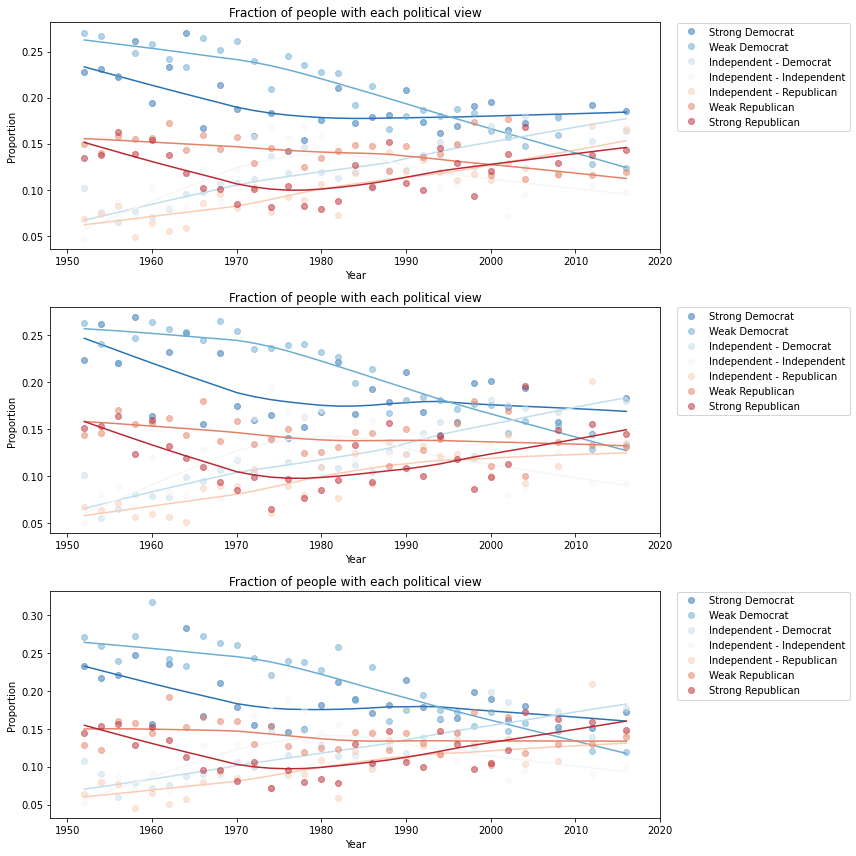

In [265]:
figure(figsize=(12, 12))
plt.subplot(311)
plot_columns_lowess(xtab, columns7, color_map7)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1948, 2020])

anchor_legend(1.02, 1.02)

plt.subplot(312)
plot_columns_lowess(xtab2, columns7, color_map7)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1948, 2020])

anchor_legend(1.02, 1.02)

plt.subplot(313)
plot_columns_lowess(xtab3, columns7, color_map7)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1948, 2020])

anchor_legend(1.02, 1.02)
plt.savefig('figures/sevenPoint.png')

There is an inflection point in the proportion of Strong Republicans around 1975, where the group went from consistently dropping, to flat, to increasing - up until the present. The proportion of Strong Democrats, on the other hand, have stayed virtually flat since the late 70s. The number of Weak Democrats has also been dropping since the late 70s. Indpedents leaning to both parties have been increasing since the beginning of the ANES data. There results are consistent results across all three samples of the data. 

For a broader look, I looked at the three party data. Once again with all three samples.

In [266]:
remap3 = {1: 'Democrat', 2: 'Independent', 3: 'Republican'}
xtab = pd.crosstab(data['year'], data['pol'].replace(remap3), normalize='index')
xtab2 = pd.crosstab(s2['year'], s2['pol'].replace(remap3), normalize='index')
xtab3 = pd.crosstab(s3['year'], s3['pol'].replace(remap3), normalize='index')

In [267]:
palette3 = sns.color_palette('RdBu_r', 3)
columns3 = ['Democrat','Independent','Republican']
color_map3 = dict(zip(columns3, palette3))

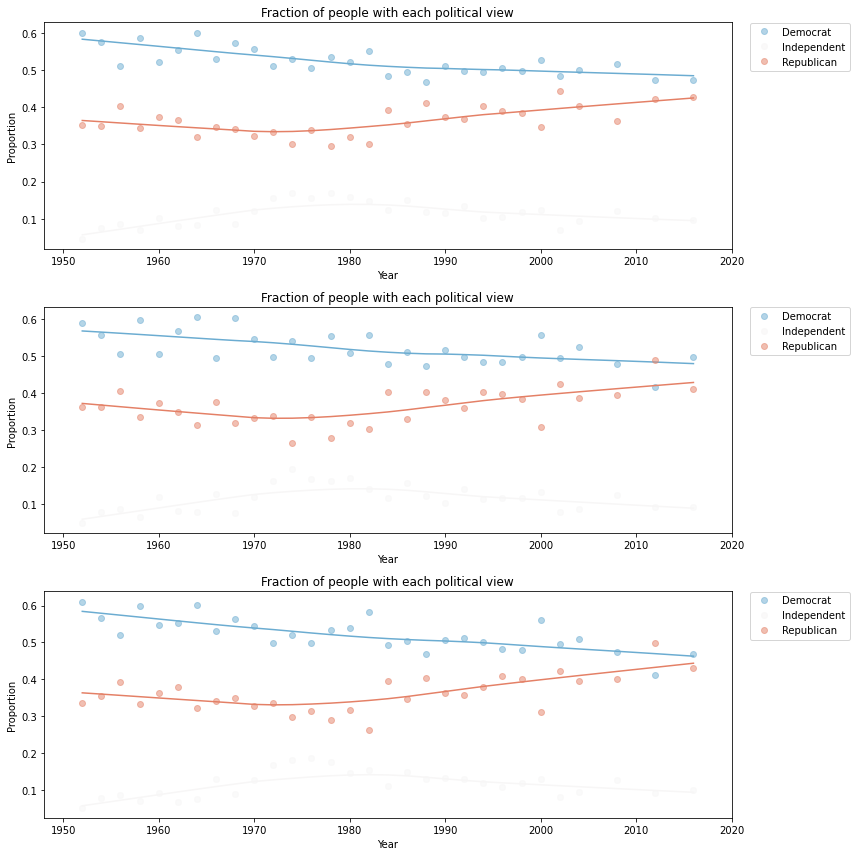

In [268]:
figure(figsize=(12, 12))
plt.subplot(311)
plot_columns_lowess(xtab, columns3, color_map3)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1948, 2020])

anchor_legend(1.02, 1.02)

plt.subplot(312)
plot_columns_lowess(xtab2, columns3, color_map3)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1948, 2020])

anchor_legend(1.02, 1.02)

plt.subplot(313)
plot_columns_lowess(xtab3, columns3, color_map3)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1948, 2020])

anchor_legend(1.02, 1.02)
plt.savefig('figures/threePoint.png')

When looking at the three category political results, there is a steady increase in the number of Republicans since the 70s. Democrats have been decreasing slowly since the start of the ANES data. 

## Gender
Grab the political affiliation for men and women:

In [269]:
female = data[data['gender']=='female']['pol7']
female.name = 'Women'
male = data[data['gender']=='male']['pol7']
male.name = 'Men'

Create the cross tabulations

In [270]:
year = data['year']
xtabFemale = pd.crosstab(year, female.replace(remap7), normalize='index')
xtabMale = pd.crosstab(year, male.replace(remap7), normalize='index')

Visualize them in regard to time to see if there are any notable changes:

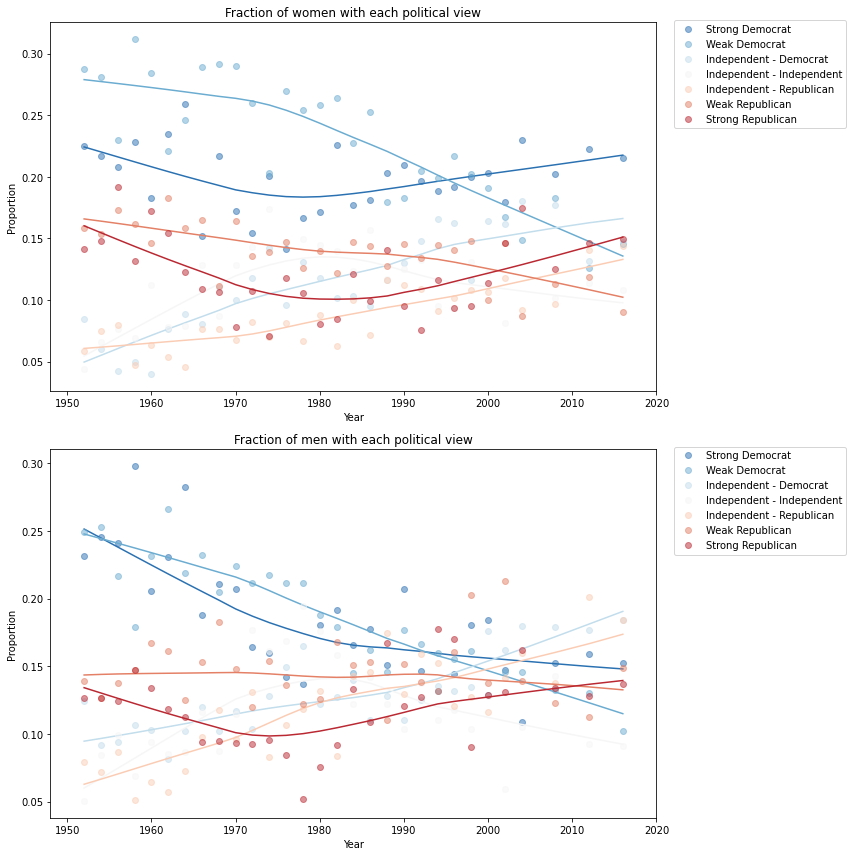

In [271]:
figure(figsize=(12, 12))
plt.subplot(211)
plot_columns_lowess(xtabFemale, columns7, color_map7)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of women with each political view',
         xlim=[1948, 2020])

anchor_legend(1.02, 1.02)

plt.subplot(212)
plot_columns_lowess(xtabMale, columns7, color_map7)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of men with each political view',
         xlim=[1948, 2020])

anchor_legend(1.02, 1.02)

The various political party affiliations for men and women generally follow the trends irregardless of gender, with differences with slope magnitude and inflection points. A noticeable exception from this rule is that the proportion of women who are Strong Democrats has been increasing since the 70s. 

And visualize the political spread of men and women irregardless of time:

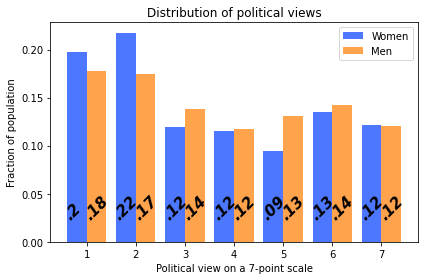

In [283]:
pmfComparison([female, male])
decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population', 
         title='Distribution of political views')

Just as a refresher, 4 is the center, 1 is the most democrat, and 7 is the most republican:

1. Strong Democrat
2. Weak Democrat
3. Independent -Democrat
4. Independent -Independent
5. Independent -Republican
6. Weak Republican
7. Strong Republican



Women are more likely to be be at the far left end of the political spectrum by a few percentage points, with men more likely to be further to the right. It looks like men may be more moderate in general than women. There is a very small difference between the number of republican men and than women (though there are still more), while there are significantly more democrat women than men.

Now I reduced the number of categories to three categories (1-3 as democrats, 5-7 as republicans, and 4 as independents), as suggested by the ANES variable.

In [105]:
female2 = data[data['gender']=='female']['pol']
female2.name = 'Women'
male2 = data[data['gender']=='male']['pol']
male2.name = 'Men'

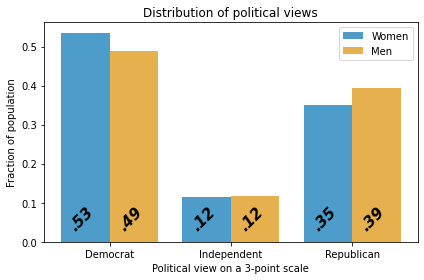

In [285]:
pmfComparison([female2, male2], tick_label = ['Democrat', 'Independent', 'Republican'], xOffset=.15)
decorate(xlabel='Political view on a 3-point scale',ylabel='Fraction of population', title='Distribution of political views')

Now it is quite a bit easier to see that women tend to lean democrat, and men tend to lean republican. There are about 4 percentage points more women democrats than men democrats. There are about 4 percentage points more men republicans than women republicans.

Now only for people who fully identify with a political party (1-2 will be democrats, 6-7 republicans, and 3-5 independents0:

In [286]:
remap = {1: 1, 2: 1, 
         3: 2, 4: 2, 5: 2, 
         6: 3, 7: 3}

female3 = female.replace(remap)
male3 = male.replace(remap)

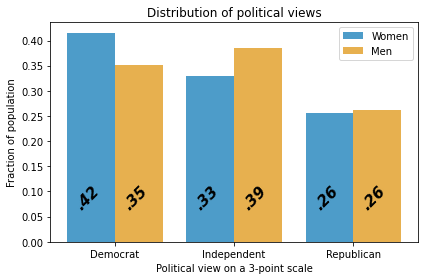

In [287]:
pmfComparison([female3, male3], tick_label = ['Democrat', 'Independent', 'Republican'], xOffset=.15)
decorate(xlabel='Political view on a 3-point scale',ylabel='Fraction of population', title='Distribution of political views')

When only looking at people who fully identitfy with a political party, women lean harder democrat than men lean republican. There are 6 percentage points more women democrats than men. There are less than 1 percenttage point more men republicans than women republicans.

## Race and Ethnicity

Grab the political affiliation for people of different races and ethnicities:

In [288]:
black = data[data['race']=='black']['pol7']
black.name = 'Black'
white = data[data['race']=='white']['pol7']
white.name = 'White'
hispanic = data[data['race']=='hispanic']['pol7']
hispanic.name = 'Hispanic'
other = data[data['race']=='other']['pol7']
other.name = 'Other'

Now for the visualization of political affiliation by race and ethnicity:

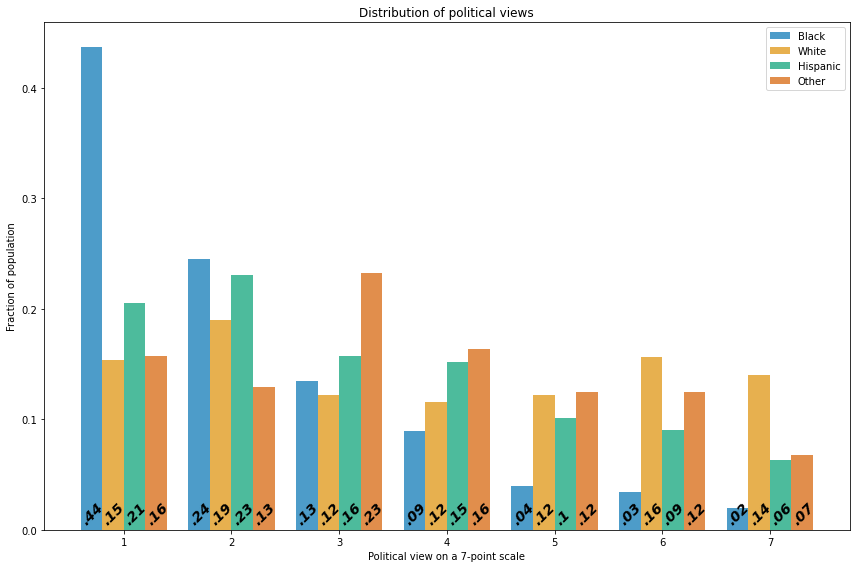

In [289]:
figure(figsize=(12, 8))
pmfComparison([black, white, hispanic, other], fontsize=14, xOffset=.08)
decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population',
         title='Distribution of political views')

Just as a refresher, 4 is the center, 1 is the most democrat, and 7 is the most republican:

1. Strong Democrat
2. Weak Democrat
3. Independent -Democrat
4. Independent -Independent
5. Independent -Republican
6. Weak Republican
7. Strong Republican



Black people are by far the most likely to be Democrat, with white people and people in the category of other races the least likely. People in the category of other races are the most moderate, which makes sense given this group is made up of many different groups of people. 

I ran the same visulation again but with the three category political variable (1-3 democrats, 4 independents, 5-7 republicans).

In [111]:
black3 = data[data['race']=='black']['pol']
black3.name = 'Black'
white3 = data[data['race']=='white']['pol']
white3.name = 'White'
hispanic3 = data[data['race']=='hispanic']['pol']
hispanic3.name = 'Hispanic'
other3 = data[data['race']=='other']['pol']
other3.name = 'Other'

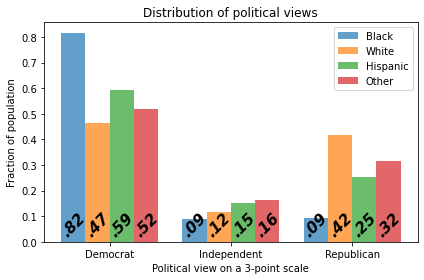

In [112]:
pmfComparison([black3, white3, hispanic3, other3], tick_label = ['Democrat', 'Independent', 'Republican'], xOffset=0.08)
decorate(xlabel='Political view on a 3-point scale',ylabel='Fraction of population', title='Distribution of political views')

Now it is quite a bit easier to see the overall differences. White people are the most likely to be Republicans, with 10 percentage points on the next highest group: people of other races. Black people are the most likely to be Democrats, with white people the  least likely. With the three group visualization, it is much easier to see the Democrat leaning of the hispanic population as well (which was not as obvious since they are less likely to be Strong Democrats than black people).

## Socio Economic Status

LGrab the political affiliation for people of different socio economic statuses:

In [113]:
lower = data[data['income']=='lower']['pol']
lower.name = 'Lower'

lowerMiddle = data[data['income']=='lowerMiddle']['pol']
lowerMiddle.name = 'Lower Middle'

middle = data[data['income']=='middle']['pol']
middle.name = 'Middle'

upperMiddle = data[data['income']=='upperMiddle']['pol']
upperMiddle.name = 'Upper Middle'

upper = data[data['income']=='upper']['pol']
upper.name = 'Upper'

Here is the translation guide from class label to income percentile:

Class Label | Percentile
--- | ---
Lower | 0 to 16 percentile
Lower Middle | 17 to 33 percentile
Middle | 34 to 67 percentile
Upper Middle | 68 to 95 percentile
Upper | 96 to 100 percentile

Now for the visualization of political affiliation by socio economic status:

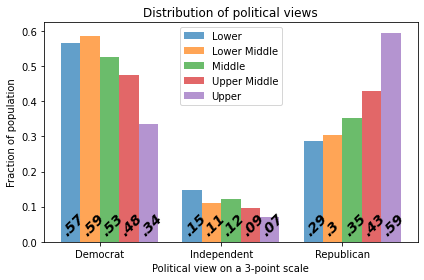

In [114]:
pmfComparison([lower, lowerMiddle, middle, upperMiddle, upper], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09)
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')

There is a clear correlation between income and political affilition. The more income someone has, the more likely they are to be Republican. The biggest difference is in people in the top four percent, who are 1.37 times more likely than people in the 68th to 95th percentile to be Republican, and about twice as likely as people in the bottom 16th percentile to be Republican. There is less of a difference when comparing people 33th percentile and lower. While there is still a correltaion where the richer, the more likely to be Republican, the differences are less strong. Lower Middle class people are only a few percent more likely than Lower class to be Republicans, and are actually more likely to be Demcrats. Compare this to Middle Class people, who are 20% more likely to be Republican than Lower class people, and 7% less likely to be Democrat.

## Age

Grab the age groups of different respondents:

In [116]:
ageOne = data[data['age']=='17-24']['pol']
ageOne.name = '17-24'

ageTwo = data[data['age']=='25-34']['pol']
ageTwo.name = '25-34'

ageThree = data[data['age']=='35-44']['pol']
ageThree.name = '35-44'

ageFour = data[data['age']=='45-54']['pol']
ageFour.name = '45-54'

ageFive = data[data['age']=='55-64']['pol']
ageFive.name = '55-64'

ageSix = data[data['age']=='65-74']['pol']
ageSix.name = '65-74'

ageSeven = data[data['age']=='75-99']['pol']
ageSeven.name = '75-99'

Now for the visualization of political affiliation by socio economic status:

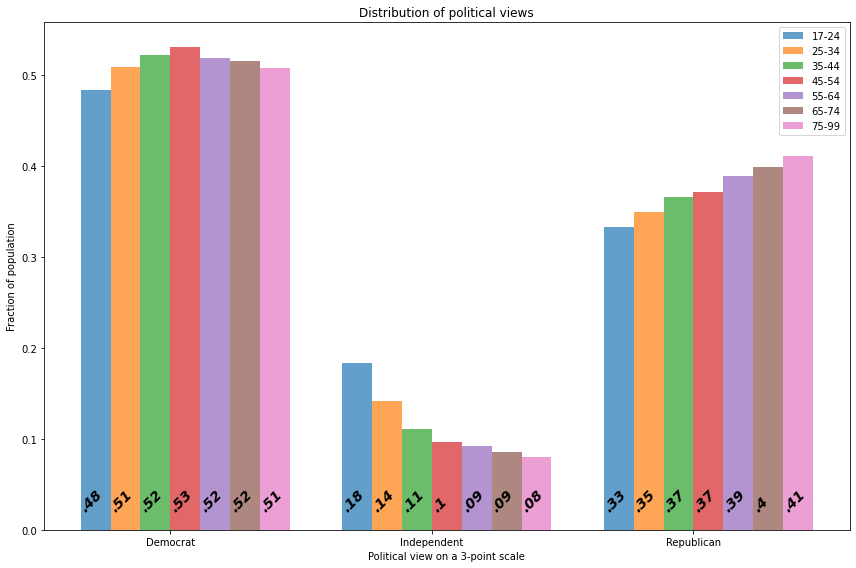

In [118]:
figure(figsize=(12, 8))
pmfComparison([ageOne, ageTwo, ageThree, ageFour, ageFive, ageSix, ageSeven], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09)
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')

The older someone is, the more likely they are to be Republican and the less likely they are to be Independent. People in the oldest cohort, 75-99, are less than half as likely to be Indepedent and are 24% more likely to be Republican than the youngest cohort, 17-24. There are sharp decreases in the number of Indepedents going from the 17-24 cohort to the 25-34 cohort, and the 25-34 cohort to the 35-44; suggesting the older one gets, the more likely they are to associate with a political party.

Democrat affiliation is relatively flat across age cohorts, peaking at 45-54 and decreasing rather evenly on either side.

## Education

In [124]:
grade = data[data['educ']=='Grade School']['pol']
grade.name = 'Grade School'

high = data[data['educ']=='High School']['pol']
high.name = 'High School'

someCollege = data[data['educ']=='Some College']['pol']
someCollege.name = 'Some College'

college = data[data['educ']=='College Degree']['pol']
college.name = 'College Degree'

Now for the visualization of political affiliation by education:

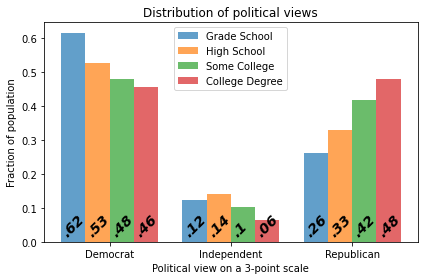

In [125]:
pmfComparison([grade, high, someCollege, college], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09)
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')

More educated people are more likely to be Republican. People with a college degree are 1.8 times more likely to be Republican than those with only a Grade School education. People with only a grade school education are 1.17 times more likely to be a Democrat when compared to people with a high education.  Where as people with some college education are only 1.1 times more likely to be a Democrat compared with people with a high school education.  

## Father Political Affiliation

Grab the political affiliation of different father's of interviewees:

In [195]:
dadDemo = data[data['fatherPol']=='Democrat']['pol']
dadDemo.name = 'Democrat Father'

dadInde = data[data['fatherPol']=='Independent']['pol']
dadInde.name = 'Independent Father'

dadRepu = data[data['fatherPol']=='Republican']['pol']
dadRepu.name = 'Republican Father'

Now for the visualization:

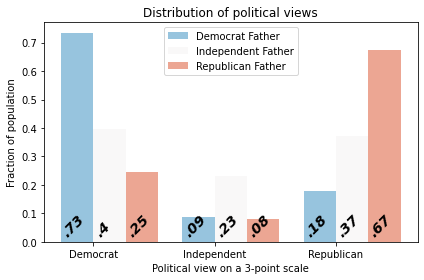

In [294]:
pmfComparison([dadDemo, dadInde, dadRepu], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09, pColor='RdBu_r')
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')
plt.savefig('figures/father.png')

Political affiliation of someone's father is a strong indicator of someone's political affiliation. 73 percent of Democrats have Democrat dads, 67 percent of Republicans have Republican dads. The only group where the majority of people depart from their father's political affiliation are peopel with a Indepedent father; only 23 percent of Independent Fathers have Indepedent children.

## Mother Political Affiliation

Grab the political affiliation of different mother's of interviewees:

In [172]:
momDemo = data[data['motherPol']=='Democrat']['pol']
momDemo.name = 'Democrat Mother'

momInde = data[data['motherPol']=='Independent']['pol']
momInde.name = 'Independent Mother'

momRepu = data[data['motherPol']=='Republican']['pol']
momRepu.name = 'Republican Mother'

Now for the visualization:

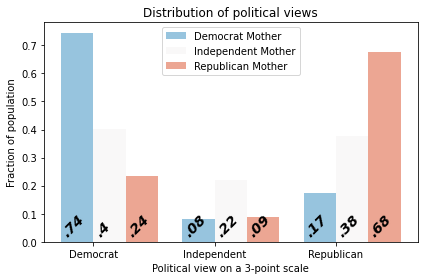

In [295]:
pmfComparison([momDemo, momInde, momRepu], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09, pColor='RdBu_r')
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')
plt.savefig('figures/mother.png')

Political affiliation of someone's mother is almost an identical indicator as a father's political affilitaion. The majority of Democrats have Democrat mothers, and the majority of Republicans have Republican mothers.

## Both Parent Political Affiliations
Grab the political affiliation of people whose parents have the same political affiliation:

In [227]:
bothDemo = (data['motherPol']=='Democrat') & (data['fatherPol']=='Democrat')
polBothDemo = (bothDemo * data['pol']).replace(0, np.nan)
polBothDemo.name = 'Democrat Parents'

bothInde = (data['motherPol']=='Independent') & (data['fatherPol']=='Independent')
polBothInde = (bothInde * data['pol']).replace(0, np.nan)
polBothInde.name = 'Independent Parents'

bothRepu = (data['motherPol']=='Republican') & (data['fatherPol']=='Republican')
polBothRepu = (bothRepu * data['pol']).replace(0, np.nan)
polBothRepu.name = 'Republican parents'

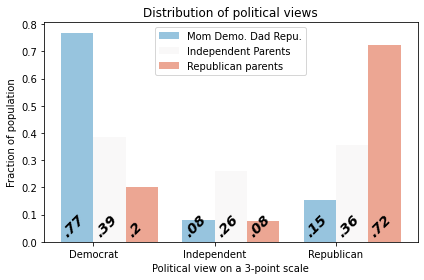

In [296]:
pmfComparison([polBothDemo, polBothInde, polBothRepu], tick_label = ['Democrat', 'Independent', 'Republican'], fontsize=14, xOffset=0.09, pColor='RdBu_r')
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title='Distribution of political views')
plt.savefig('figures/parent.png')

When both parents have the same political affiliaton, it is a good indicator of the child's political affiliaton. 77% of Democrat parents have Democrat children. 72% of Republican parents have Republican children. Just like with individual parents being Independent, most people with Independent parents do not turn out to be Independent.

Look at all parent permutations:

In [311]:
# already have both demo, rep, ind
a = (data['motherPol']=='Democrat') & (data['fatherPol']=='Independent')
b = (data['motherPol']=='Independent') & (data['fatherPol']=='Democrat')
demInd = ((a | b)*data['pol']).replace(0, np.nan)

a = (data['motherPol']=='Democrat') & (data['fatherPol']=='Republican')
b = (data['motherPol']=='Republican') & (data['fatherPol']=='Independent')
demRep = ((a | b)*data['pol']).replace(0, np.nan)

a = (data['motherPol']=='Republican') & (data['fatherPol']=='Independent')
b = (data['motherPol']=='Independent') & (data['fatherPol']=='Republican')
repInd = ((a | b)*data['pol']).replace(0, np.nan)

polBothDemo.name = 'Both Dem'
polBothRepu.name = 'Both Rep'
polBothInde.name = 'Both Ind'
demInd.name = 'Dem and Ind'
demRep.name = 'Dem and Rep'
repInd.name = 'Rep and Ind'


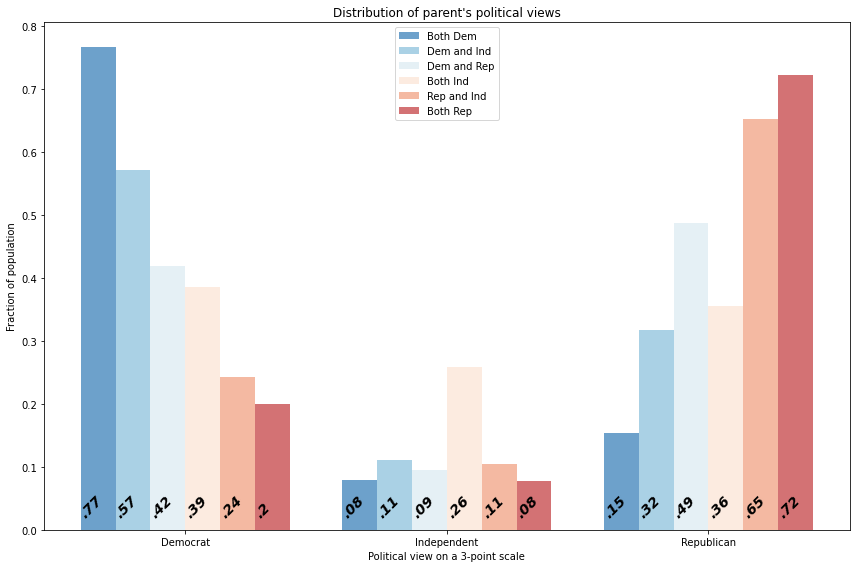

In [314]:
figure(figsize=(12, 8))
pmfComparison([polBothDemo, demInd, demRep, polBothInde, repInd, polBothRepu], 
              tick_label = ['Democrat', 'Independent', 'Republican'], 
              fontsize=14, xOffset=0.09, pColor='RdBu_r')
decorate(xlabel='Political view on a 3-point scale', ylabel='Fraction of population', title="Distribution of parent's political views")
plt.savefig('figures/parentPer.png')

Children of parents whose political beliefs whose align are more likely to end up with that belief than if they do not. If a child has a partisan and an Indepedent parent, they are almost 90% likely to end up partisan, over 57% likely to end up with their partisan's parent view. When a person has a Republican and Democrat parent, they are around 17% more likely to be a Republican than a Democrat.